<a href="https://colab.research.google.com/github/animeqvin/Apnea_Detection/blob/main/Apnea_Detection_from_Simulated_ECG_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft
from scipy.signal.windows import gaussian

In [179]:
%matplotlib inline

label_file = 'a03.apn.txt'
labels = pd.read_csv(label_file, sep='\s+')
time_labels = labels['Time'].values
apnea_labels = labels['Label'].values

In [180]:
fs_original = 100
duration_sec = 4 * 3600
n_samples = duration_sec * fs_original
t = np.arange(n_samples) / fs_original

In [181]:
ecg_signal = 0.5 * np.sin(2*np.pi*1.2*t) + 0.2*np.sin(2*np.pi*2*t) + 0.05*np.random.randn(len(t))

In [182]:
for idx, label in enumerate(apnea_labels):
    start_sec = idx * 60
    end_sec = (idx + 1) * 60
    start_idx = int(start_sec * fs_original)
    end_idx = int(end_sec * fs_original)
    if label == 'A' and start_idx < len(ecg_signal) and end_idx <= len(ecg_signal) and end_idx > start_idx:
        apnea_time = np.linspace(0, 60, end_idx - start_idx)
        apnea_signal = 0.2 * np.sin(2*np.pi*0.8*apnea_time) + 0.05*np.random.randn(end_idx - start_idx)
        random_mask = np.random.choice([0, 1], size=(end_idx - start_idx), p=[0.5, 0.5])
        apnea_signal *= random_mask
        ecg_signal[start_idx:end_idx] = apnea_signal

In [183]:
fs_new = 500
t_new = np.arange(0, duration_sec, 1/fs_new)
ecg_resampled = signal.resample(ecg_signal, len(t_new))

In [184]:
cutoff_freq = 30  # Hz
b, a = signal.butter(5, cutoff_freq / (fs_new / 2), btype='low')
ecg_filtered = signal.filtfilt(b, a, ecg_resampled)

In [185]:
window_size = int(60 * fs_new)
num_windows = len(ecg_filtered) // window_size
avg_hr = []
std_hr = []
num_peaks_list = []

In [186]:
for i in range(num_windows):
    segment = ecg_filtered[i*window_size:(i+1)*window_size]
    peaks, _ = signal.find_peaks(segment, height=0.3*np.max(segment), distance=fs_new*0.3)
    num_peaks_list.append(len(peaks))
    if len(peaks) > 1:
        rr = np.diff(peaks) / fs_new
        hr = 60 / rr
        avg_hr.append(np.mean(hr))
        std_hr.append(np.std(hr))
    else:
        avg_hr.append(np.nan)
        std_hr.append(np.nan)

time_minutes = np.arange(1, num_windows+1)

In [187]:
# dominant frequency
fs_low = 4  # Hz
detected_labels = []
for i in range(num_windows):
    segment = ecg_filtered[i*window_size:(i+1)*window_size]
    segment_low = signal.resample(segment, 60*fs_low)
    fft_segment = fft(segment_low)
    power_segment = np.abs(fft_segment[:len(segment_low)//2])**2 / len(segment_low)
    freq_axis = np.linspace(0, fs_low/2, len(power_segment))
    peak_freq = freq_axis[np.argmax(power_segment)]
    if peak_freq < 1.0:
        detected_labels.append('A')
    else:
        detected_labels.append('N')

In [188]:
true_labels = apnea_labels[:num_windows]
accuracy = np.mean(np.array(detected_labels) == np.array(true_labels)) * 100
print(f'Detection Accuracy: {accuracy:.2f}%')

Detection Accuracy: 100.00%


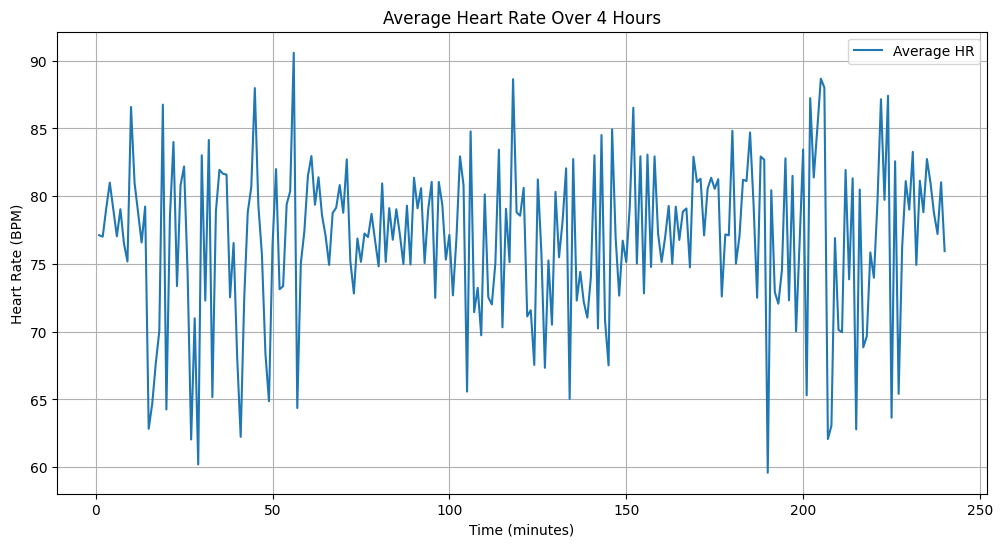

In [189]:
plt.figure(figsize=(12,6))
plt.plot(time_minutes, avg_hr, label='Average HR')
plt.xlabel('Time (minutes)')
plt.ylabel('Heart Rate (BPM)')
plt.title('Average Heart Rate Over 4 Hours')
plt.grid()
plt.legend()
plt.savefig('average_hr.png')
plt.show()

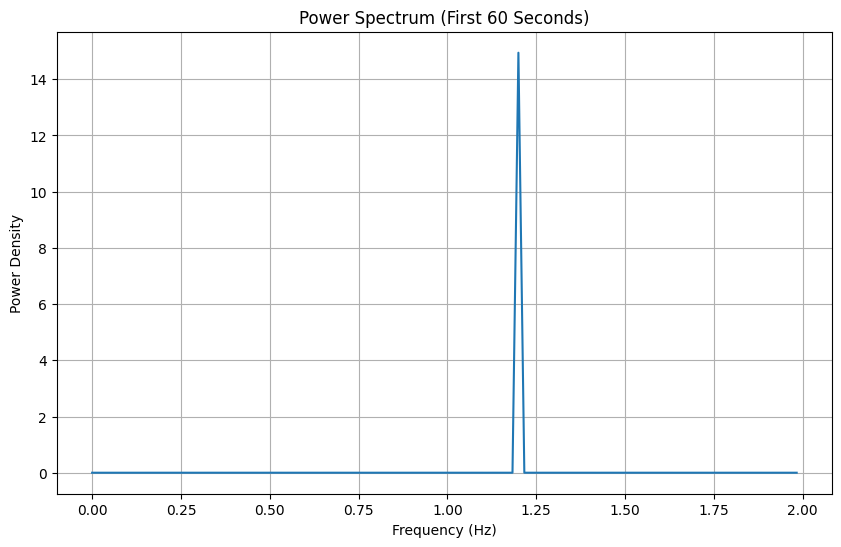

In [190]:
# first 60 sec
segment_60s = ecg_filtered[0:window_size]
segment_60s_low = signal.resample(segment_60s, 60*fs_low)
freq_axis = np.linspace(0, fs_low/2, int(60*fs_low/2), endpoint=False)
power_density = np.abs(fft(segment_60s_low)[:len(segment_60s_low)//2])**2 / len(segment_60s_low)

plt.figure(figsize=(10,6))
plt.plot(freq_axis, power_density)
plt.title('Power Spectrum (First 60 Seconds)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Density')
plt.grid()
plt.savefig('power_spectrum.png')
plt.show()

In [191]:
# spectrogram for 4h
spectrogram = []
for i in range(num_windows):
    segment = ecg_filtered[i*window_size:(i+1)*window_size]
    segment_low = signal.resample(segment, 60*fs_low)
    fft_segment = fft(segment_low)
    power_segment = np.abs(fft_segment[:len(segment_low)//2])**2 / len(segment_low)
    spectrogram.append(power_segment)

spectrogram = np.array(spectrogram).T

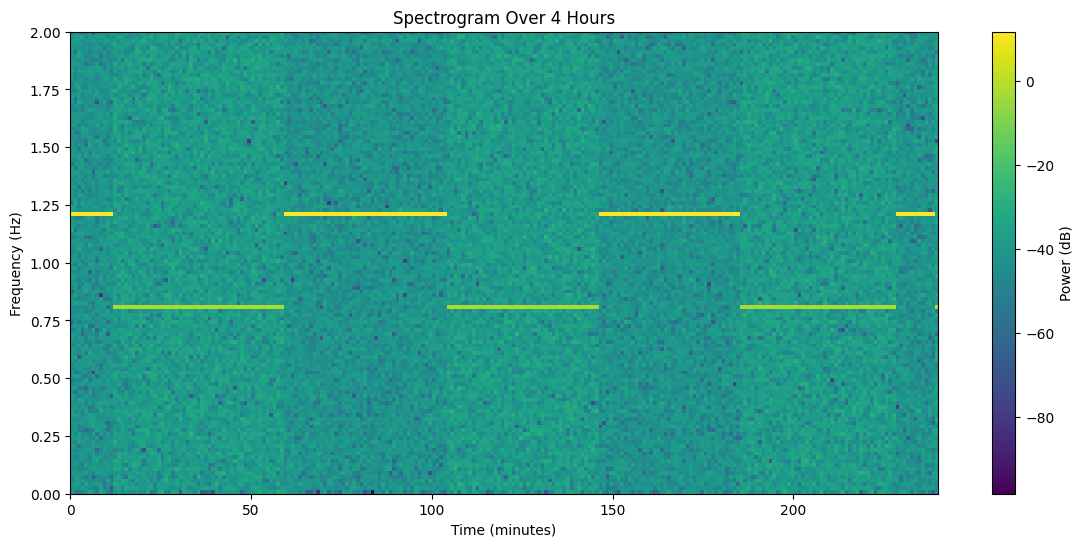

In [192]:
plt.figure(figsize=(14,6))
plt.imshow(10*np.log10(spectrogram + 1e-10), aspect='auto', extent=[0, 4*60, 0, fs_low/2], origin='lower', cmap='viridis')
plt.colorbar(label='Power (dB)')
plt.xlabel('Time (minutes)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram Over 4 Hours')
plt.savefig('spectrogram.png')
plt.show()

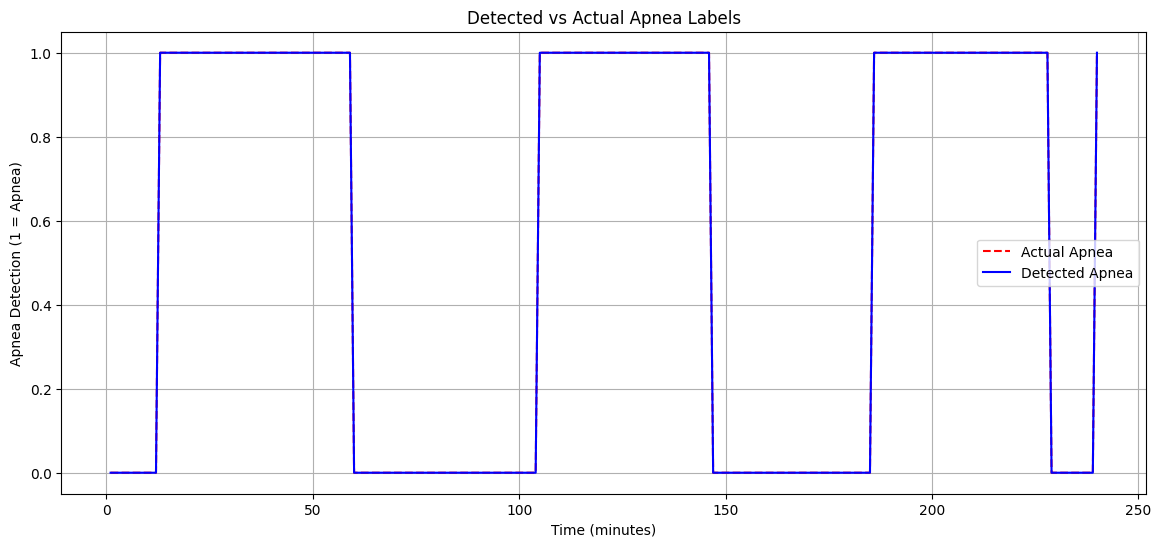

In [193]:
plt.figure(figsize=(14,6))
plt.plot(time_minutes, (np.array(true_labels) == 'A').astype(int), 'r--', label='Actual Apnea')
plt.plot(time_minutes, (np.array(detected_labels) == 'A').astype(int), 'b-', label='Detected Apnea')
plt.xlabel('Time (minutes)')
plt.ylabel('Apnea Detection (1 = Apnea)')
plt.title('Detected vs Actual Apnea Labels')
plt.legend()
plt.grid()
plt.savefig('apnea_detection.png')
plt.show()